## Import

In [2]:
# importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import chain

# for reading and displaying images
import matplotlib.pyplot as plt
from glob import glob

# for creating validation set
from sklearn.model_selection import train_test_split

# PyTorch libraries and modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dset
from torch.utils.data import DataLoader

# models
from src.dataloader import *
from src.architectures.resnet import *
from src.architectures.levakov_96 import *
from src.architectures.inception import *
from src.architectures.dinsdale import *

from src.run import *

from torch.optim import *
import torch.optim as optim
from torchsummary import summary

# CAM
from PIL import Image
from matplotlib.pyplot import imshow

from medcam import medcam

## Load Model

In [3]:
def load_model(model, verbose=True):
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Model {model.capitalize()} is selected.')

    if model == 'resnet':
        

        opt = Option()
        model = generate_model(model_depth=opt.model_depth,
                                    n_classes=opt.n_classes,
                                    n_input_channels=opt.n_input_channels,
                                    shortcut_type=opt.shortcut_type,
                                    conv1_t_size=opt.conv1_t_size,
                                    conv1_t_stride=opt.conv1_t_stride,
                                    no_max_pool=opt.no_max_pool,
                                    widen_factor=opt.resnet_widen_factor)

    elif model == 'levakov':
        model = Levakov(task_type='age')

    elif model == 'inception':
        model = Inception3()

    elif model == 'dinsdale':
        model = Dinsdale(1, 1, 2)

    else: return None

    model.to(device)
    if verbose:
        print(summary(model, input_size=(1, 96, 96, 96)))
    
    return model, device

model = 'resnet'
model, device = load_model(model)

Model Resnet is selected.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 16, 96, 48, 48]           2,352
       BatchNorm3d-2       [-1, 16, 96, 48, 48]              32
              ReLU-3       [-1, 16, 96, 48, 48]               0
         MaxPool3d-4       [-1, 16, 48, 24, 24]               0
            Conv3d-5       [-1, 16, 48, 24, 24]           6,912
       BatchNorm3d-6       [-1, 16, 48, 24, 24]              32
              ReLU-7       [-1, 16, 48, 24, 24]               0
            Conv3d-8       [-1, 16, 48, 24, 24]           6,912
       BatchNorm3d-9       [-1, 16, 48, 24, 24]              32
             ReLU-10       [-1, 16, 48, 24, 24]               0
       BasicBlock-11       [-1, 16, 48, 24, 24]               0
           Conv3d-12       [-1, 32, 24, 12, 12]          13,824
      BatchNorm3d-13       [-1, 32, 24, 12, 12]              64
             

## Setups

Default Settings

In [4]:
model = torch.load('models/resnet_200_elastic_6.949.pth')

In [5]:
task_type = 'age' # no longer used.
resize = True
scheduler = False
epochs = range(200)
fold = None

from src.losses import RMSELoss

loss_fn = nn.MSELoss()
lamb = 0.0005
rmse_fn = RMSELoss()
mae_fn = nn.L1Loss()

In [6]:
model = medcam.inject(model, output_dir="attention_maps/tmp/", retain_graph=True, layer='conv1')
model, (tst_losses, tst_maes, tst_rmses), tst_preds = eval(model, True, None, fold, resize, device, 1,
                                                       loss_fn, mae_fn, rmse_fn,
                                                       [], [], [])

# Attention Maps

./attention_maps/conv1/*.nii.gz

In [8]:
path = glob('./attention_maps/conv1/*.nii.gz')

In [11]:
avg_map = nib.load(path[0]).get_fdata()
for att in path[1:]:
    
    avg_map += nib.load(att).get_fdata()
    
avg_map /= len(path)
avg_map

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [16]:
att_map_0 = nib.load(path[0]).get_fdata()

In [17]:
att_map_0.shape

(48, 48, 96)

In [18]:
import seaborn as sns

<AxesSubplot:>

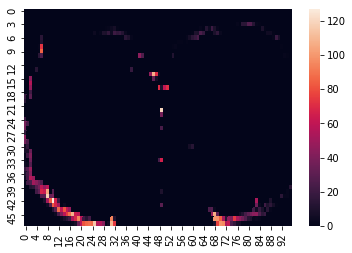

In [19]:
sns.heatmap(att_map_0[24])

<AxesSubplot:>

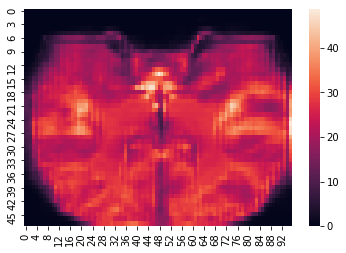

In [12]:
sns.heatmap(avg_map[24, :, :])

<AxesSubplot:>

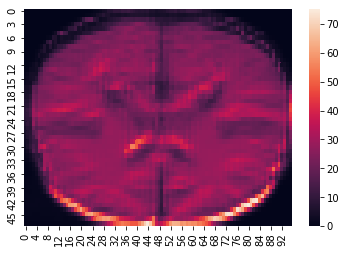

In [20]:
sns.heatmap(avg_map[:, 28, :])

<AxesSubplot:>

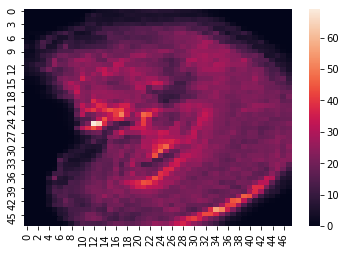

In [14]:
sns.heatmap(avg_map[:, :, 47])

In [35]:
dset = MyDataset(task_type='age', test=True, augment=None, fold=None)
dataloader = DataLoader(dset, batch_size=1)

In [37]:
next(iter(dataloader))[0]

tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          ...,

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           

./attention_maps/tmp/

In [17]:
path = './attention_maps/tmp/conv1/*'

In [18]:
glob(path)

['./attention_maps/tmp/conv1\\attention_map_0_0_0.nii.gz',
 './attention_maps/tmp/conv1\\attention_map_1_0_0.nii.gz',
 './attention_maps/tmp/conv1\\attention_map_2_0_0.nii.gz',
 './attention_maps/tmp/conv1\\attention_map_3_0_0.nii.gz',
 './attention_maps/tmp/conv1\\attention_map_4_0_0.nii.gz',
 './attention_maps/tmp/conv1\\attention_map_5_0_0.nii.gz',
 './attention_maps/tmp/conv1\\attention_map_6_0_0.nii.gz',
 './attention_maps/tmp/conv1\\attention_map_7_0_0.nii.gz',
 './attention_maps/tmp/conv1\\attention_map_8_0_0.nii.gz',
 './attention_maps/tmp/conv1\\attention_map_9_0_0.nii.gz',
 './attention_maps/tmp/conv1\\attention_map_10_0_0.nii.gz',
 './attention_maps/tmp/conv1\\attention_map_11_0_0.nii.gz',
 './attention_maps/tmp/conv1\\attention_map_12_0_0.nii.gz',
 './attention_maps/tmp/conv1\\attention_map_13_0_0.nii.gz',
 './attention_maps/tmp/conv1\\attention_map_14_0_0.nii.gz',
 './attention_maps/tmp/conv1\\attention_map_15_0_0.nii.gz',
 './attention_maps/tmp/conv1\\attention_map_16_0_0